In [1]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats

## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')


import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

In [2]:
def train_test_scorer(x,y, inst_fr):
    target1 = (x-np.mean(x))/np.std(x)
    target2 = (y-np.mean(y))/np.std(y)

    train_size = 8000
    test_size = 1000
    buffer = int((dt-train_size-test_size)/2)
    for i in range(0, int(len(inst_fr)/dt)):
        if i == 0:
            X_train = inst_fr[i*dt : i*dt + train_size,:]
            y_train1 = target1[i*dt : i*dt + train_size]
            y_train2 = target2[i*dt : i*dt + train_size]
            X_test = inst_fr[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size,:]
            y_test1 = target1[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size]
            y_test2 = target2[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size]
        else:
            X_train  = np.vstack((X_train, inst_fr[i*dt + buffer: i*dt + train_size+ buffer]))
            ##print('training', i*dt + buffer,i*dt + train_size+ buffer)
            X_test = np.vstack((X_test, inst_fr[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size,:]))
            ##print('testing',(i)*dt + train_size + 2*buffer,((i)*dt + train_size + 2*buffer+test_size))
            y_train1 = np.append(y_train1, target1[i*dt+ buffer: i*dt + train_size+ buffer])
            y_test1 = np.append(y_test1, target1[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size])

            y_train2 = np.append(y_train2, target2[i*dt+ buffer: i*dt + train_size+ buffer])
            y_test2 = np.append(y_test2, target2[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size])

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)        

    model = LinearRegression()
    model.fit(X_train, y_train1)

    model2 = LinearRegression()
    model2.fit(X_train, y_train2)
    
    
    train_score = (model.score(X_train, y_train1) + model2.score(X_train, y_train2))/2
    test_score = (model.score(X_test, y_test1) + model2.score(X_test, y_test2))/2
    ##print('model score', model.score(X_train, y_train1))
    ##ypred = model.predict(X_train)
    ##print('r2 function', r2_score(y_train1, ypred))
    return(np.array([train_score, test_score]))



In [15]:
## Reading in file with all data
file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
alldat = pickle.load(file)

## performance of all cells with shuffle performance
dt = 10000
num_rep = 100
store_dir = '../DATA/FILES/'
all_num_repeat= []
all_num = []
all_rats = list(alldat.keys())
all_rat_day = []
all_scores = []

## for permutation test
num_shuff = 1000
alpha = 0.05
each_side = int((alpha/2)*num_shuff)
train_test_95 = []

for rat in all_rats:  
    all_days = list(alldat[rat].keys())
    for day in all_days:
        print(rat, day)
        day_scores = np.zeros((num_rep,2))
        inst_fr = np.load(store_dir + rat + '_' + day + '_inst_fr.npy')
        x_order = np.load(store_dir + rat + '_' + day + '_x_within.npy')
        y_order = np.load(store_dir + rat + '_' + day + '_y_within.npy')
        ## actual data
        for rep in range(0,num_rep):
            all_rat_day.append(rat+ '_' + day)
            
            shuff_start = np.random.choice(len(inst_fr),1)[0]
            shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
            
            x = np.concatenate((x_order[shuff_start:], x_order[0:shuff_start]))
            y = np.concatenate((y_order[shuff_start:], y_order[0:shuff_start]))
            day_scores[rep, :] = train_test_scorer(x,y, shuff_inst_fr)
        all_scores.append(day_scores)
        ## permutation test
        all_perm_scores = np.zeros((num_shuff,2))
        for perm in range(0,num_shuff):
            if perm%100== 0:
                print(perm)
            shuff_start = np.random.choice(len(inst_fr),1)[0]
            shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
            all_perm_scores[perm] = train_test_scorer(x_order,y_order, shuff_inst_fr)
        train_test_95.append(np.array([np.sort(all_perm_scores[:,0])[-each_side], np.sort(all_perm_scores[:,1])[-each_side]]))


R765 RFD5
0
100
200
300
400
500
600
700
800
900
R765 DFD4
0
100
200
300
400
500
600
700
800
900
R781 D3
0
100
200
300
400
500
600
700
800
900
R781 D4
0
100
200
300
400
500
600
700
800
900
R808 D6
0
100
200
300
400
500
600
700
800
900
R808 D7
0
100
200
300
400
500
600
700
800
900
R859 D1
0
100
200
300
400
500
600
700
800
900
R859 D2
0
100
200
300
400
500
600
700
800
900
R886 D1
0
100
200
300
400
500
600
700
800
900
R886 D2
0
100
200
300
400
500
600
700
800
900


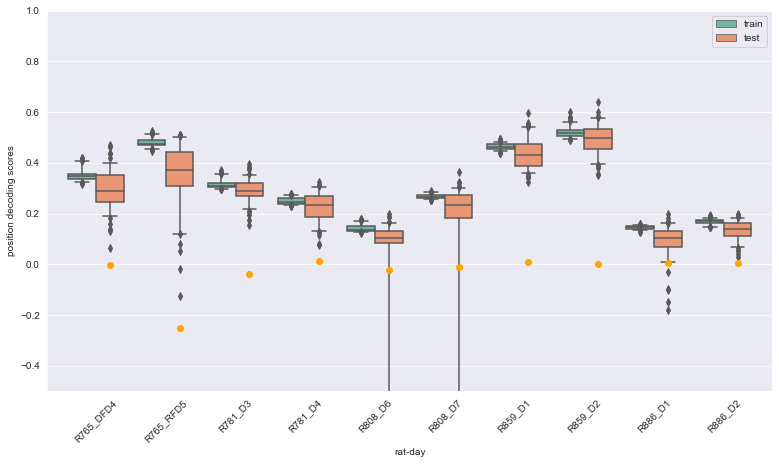

In [16]:
## plots figure

all_scores = np.array(all_scores)
score_df = pd.DataFrame(all_scores[:,:,0].flatten(), columns = ['score'])
score_df['rat-day'] = np.array(all_rat_day)
score_df['train-test'] = ['train']*len(all_rat_day)

score_df2= pd.DataFrame(all_scores[:,:,1].flatten(), columns = ['score'])
score_df2['rat-day'] = np.array(all_rat_day)
score_df2['train-test'] = ['test']*len(all_rat_day)

score_df_all = pd.concat([score_df, score_df2])

fig, ax = plt.subplots(figsize = (13,7))
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.boxplot(x = score_df_all['rat-day'], y = score_df_all['score'], hue = score_df_all['train-test'], whis=[5, 95])
## box inter-quartile range
## whiskers whis=[2.5, 97.5]
## whiskers whis=[5, 95]
ax.set_xticklabels(np.unique(all_rat_day),rotation = 45)
ax.set_ylabel('position decoding scores')

## axis limited, because some outliers very extreme, smushes everything else
ax.set_ylim(-0.5, 1)
##ax.plot(np.linspace(-0.2, 8.8, 10),np.array(train_test_95)[:,0],'o')


ax.plot(np.linspace(0.2, 9.2, 10),np.array(train_test_95)[:,1],'o', color = 'orange')
ax.legend()
plt.show()

In [18]:
## Statistics
## Binomial test
num_not_cross = 0
num_rat_days = len(train_test_95)
all_test_lim = np.array(train_test_95)[:,1]
for i in range(num_rat_days):
    ##print(np.sort(all_scores[i,:,1]))
    print(np.percentile(all_scores[i,:,1], 5), all_test_lim[i])
    if np.percentile(all_scores[i,:,1], 5)> all_test_lim[i]:
        num_not_cross = num_not_cross + 1
        print('ok')
print(num_not_cross)
print(scipy.stats.binom_test(num_not_cross,num_rat_days, p = 0.05, alternative = "greater"))


0.18905521748019782 -0.0042349995860456735
ok
0.11879150120000678 -0.24997117704225447
ok
0.21752269210150196 -0.038636747192510534
ok
0.12911141846265392 0.012056949079278845
ok
-6.906559089258839 -0.02363216340439045
-1.4990571991094626 -0.00889164849507107
0.35912544274007485 0.010471393963706777
ok
0.3966856870924538 0.00021302917617604944
ok
0.005863986764200972 0.0030810255227588512
ok
0.0661446082858604 0.006638576106911043
ok
8
1.6050781250000006e-09
